In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from numpy import linalg as LA

In [4]:
#Define the loss function
#negative loglikelihood
def LASSO_loss(X, y, theta, lamda):
    Z = - X @ theta
    N = X.shape[0]
    t=0
    for i in range(N):
        t+= np.dot(X[i], theta[:,np.argmax(y[i])])
    return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) + lamda * (LA.norm(theta))**2
#     return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) 

# Define the gradient of the loss function
def full_grad_loss(X, y, theta, lamda):
    '''Return the gardient of the logistic LASSO loss at point `theta`.'''
    n = X.shape[0]
    Z = - X @ theta
    P = softmax(Z, axis=1)
    return 1/n * (X.T @ (y - P)) + 2*lamda*theta

def grad(X, y, theta, lamda, i):
    '''Return the gardient of the logistic LASSO loss at point `theta` for datam i.'''
    Z = - X[i] @ theta
    P = softmax(Z)
    X_iT= np.reshape(X[i].T,((X[i].T).shape[0],1))
    diff = y[i] - P
    diff = np.reshape(diff,(1,diff.shape[0]))
    ans= X_iT @ diff
    
    return ans+ 2*lamda*theta

In [5]:
def SVRG(X, y, X_test, y_test, theta, lamda, max_iter, max_iter_inner, step_size):
    n, p = X.shape
    theta_hat_history = []
    loss_history = []
    test_err=[]
    theta_history = np.zeros((max_iter_inner, theta.shape[0],theta.shape[1]))

    theta_hat = theta
    
    for t in range(max_iter):
        full_gradient = full_grad_loss(X, y, theta_hat, lamda)
        for k in range(max_iter_inner):
            i = np.random.randint(0, n)
            theta = theta - step_size * (grad(X, y, theta, lamda, i) - grad(X, y, theta_hat, lamda, i) + full_gradient)
            theta_history[k] = theta
#             print(k)
            
        theta_hat = np.mean(theta_history, axis=0)
        
        theta_hat_history.append(theta_hat)
        loss_history.append(LASSO_loss(X, y, theta_hat, lamda))
        test_err.append(1-predict(X_test,y_test, theta_hat))
        print(t, loss_history[t])
    
    return theta_hat, theta_hat_history, loss_history, test_err

In [6]:
def predict(x_test, y_test, theta):
    Z= -x_test @ theta
    P = softmax(Z, axis=1)
    pred = np.argmax(P, axis=1)
    corr = np.argmax(y_test, axis=1)
    acc = sum((pred==corr).astype(np.int))/y_test.shape[0]
#     print(acc)
    return acc
    

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.python.framework import ops
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)
x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Xm=np.mean(x_train, axis=0)
# Xd =np.std(x_train, axis=0)
# Xm = np.tile(Xm, (x_train.shape[0],1))
# x_train = x_train - Xm
# # x_train = x_train/Xd

# Xm=np.mean(x_test, axis=0)
# Xd =np.std(x_test, axis=0)
# Xm = np.tile(Xm, (x_test.shape[0],1))
# x_test = x_test - Xm
# x_test = x_test/Xd

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)



Instructions for updating:
non-resource variables are not supported in the long term
11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [8]:
theta = np.zeros((784,10))
epochs=100
svrg_theta_hat, svrg_theta_hat_history, svrg_loss_history, svrg_test_err = SVRG(x_train, y_train,x_test, y_test, theta, lamda=0.0001, max_iter=epochs, 
                                                                max_iter_inner=5000, step_size=0.025 )

<ipython-input-6-a338dbd9042e>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0 0.4176760354276115
1 0.37506023039058245
2 0.32816248954436444
3 0.31285534509619556
4 0.3054488145296972
5 0.3010376438372149
6 0.2980190473653654
7 0.2957853786743275
8 0.29404372592674266
9 0.2926508655962446
10 0.2914977457138102
11 0.2905391401280464
12 0.289729516165167
13 0.28903609264191266
14 0.28844024888029224
15 0.28792298128339633
16 0.2874729320358633
17 0.287077510608298
18 0.2867289010375705
19 0.2864211517089199
20 0.28614803711581915
21 0.2859045195844564
22 0.285686547672694
23 0.2854914413738502
24 0.28531623834802583
25 0.2851585605165792
26 0.28501611653675424
27 0.2848872960018128
28 0.2847705185543768
29 0.2846645285286801
30 0.2845681398077927
31 0.2844804302300073
32 0.2844004774029407
33 0.28432764436672686
34 0.28426115279708647
35 0.2842003538152394
36 0.28414465112764015
37 0.28409355523660784
38 0.28404666311754817
39 0.284003594577783
40 0.28396398317568183
41 0.2839275626853355
42 0.28389400590017416
43 0.2838630514836701
44 0.28383452257464253
45 0.2

No handles with labels found to put in legend.


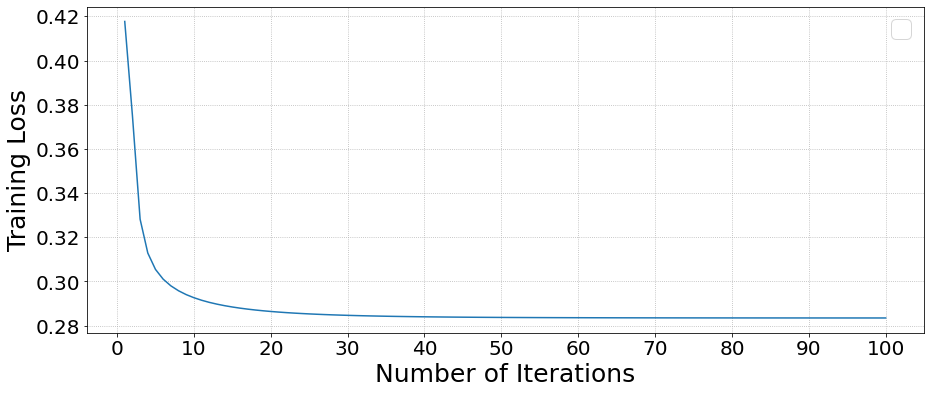

No handles with labels found to put in legend.


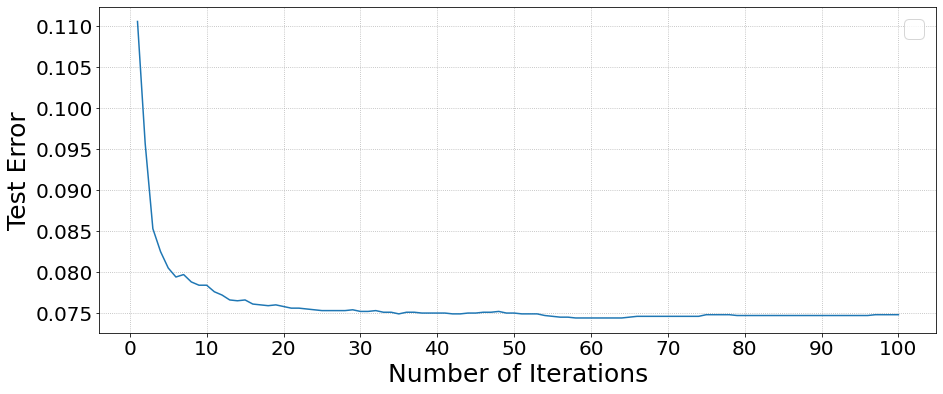

In [9]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history)
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_test_err)
plt.show()


In [10]:

# Define the function to find the mod index
def find_index(t, loop_params):
    """ finds r = min{j: 0=(m mod Prod(T_l)), 0<=j<=K}
    """
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0

def update_reference_points(theta_reference, theta, r):
    """ updates the reference points
    """
    updated_reference = theta_reference.copy()
    K, p, p1 = theta_reference.shape
    to_update = np.broadcast_to(theta, shape=(K - r, theta.shape[0],theta.shape[1]))
    updated_reference[r:] = to_update
    
    return updated_reference

def update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size):
    """ updates the gradients of reference points
    """
    n = X.shape[0]
    K, p, p1 = theta_reference.shape
    for l in range(r, K):
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda)
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda) \
                            - full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l-1], lamda)
                
    return gradients

In [11]:
def one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size):
    assert len(loop_params) == len(batch_params), "The number of loop parameters should be the same as that of batch parameters!"
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n, p = X.shape
    theta_reference = np.broadcast_to(theta, shape=(K+1, theta.shape[0],theta.shape[1]))
    theta_history = []
    
    # initialization
    gradients = np.zeros((K+1, theta.shape[0],theta.shape[1]))
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    base_batch = indexes[0:base_batch_size]
    gradients[0] = full_grad_loss(X[base_batch], y[base_batch], theta, lamda)
    grad = np.sum(gradients, axis=0)
    theta = theta - 0.1 / step_size * grad
    theta_history.append(theta)
    
    # loop
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        theta_reference = update_reference_points(theta_reference, theta, r)
        gradients = update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size)
        grad = np.sum(gradients, axis=0)
        theta = theta - 0.1 / step_size * grad
        
        theta_history.append(theta)
        
    final_theta = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    final_loss = LASSO_loss(X, y, final_theta, lamda)
    
    return final_theta, theta_history[-1], final_loss

In [12]:
# The SNVRG algorithm, with several one_epoch_SNVRG iterations
def SNVRG(X, y, X_test, y_test, theta, lamda, max_iter, loop_params, batch_params, base_batch_size, step_size):
    theta_history = []
    loss_history = []
    test_err=[]
    for t in range(max_iter):
        theta_hat, theta, loss = one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size)
        theta_history.append(theta_hat)
        loss_history.append(loss)
        #theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
        test_err.append(1-predict(X_test,y_test,theta_hat))
        print(t, loss)

    theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    return theta_hat, theta_history, loss_history, test_err

In [38]:
epochs=100
theta = np.zeros((784,10))
# loop_params = [100,100,100,100,100,100,100,100,100,100]
loop_params= [5000]
base_batch_size = 50000
# batch_params = [1,1,1,1,1,1,1,1,1,1]
batch_params=[1]
step_size = 10
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history, snvrg_test_err = SNVRG(x_train, y_train, x_test, y_test, theta, 0.0001, epochs, loop_params, batch_params, base_batch_size, step_size)
# snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history = SNVRG(x_train, y_train, theta, 0.1, 5, loop_params, batch_params, base_batch_size, step_size)

<ipython-input-6-a338dbd9042e>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0 1.2208560105449666
1 0.3633115722803657
2 0.3501492432564448
3 0.33646299788463196
4 0.3228182342062415
5 0.31803729444545686
6 0.31569168935697706
7 0.3119410618910537
8 0.30814708307150523
9 0.30664013693818304
10 0.30337719145646025
11 0.301785147516993
12 0.3008211442906492
13 0.30018017678192593
14 0.2983092925434492
15 0.2976473013319749
16 0.29709469067201344
17 0.2958330433385344
18 0.2948787581443111
19 0.294301234373271
20 0.2937193992735556
21 0.2933265157672904
22 0.2927508439522505
23 0.292030021725773
24 0.29179764242240225
25 0.29122882770922764
26 0.29076996713386516
27 0.2905964573133735
28 0.29019723997241104
29 0.2898336166102767
30 0.28965575486514744
31 0.28949038404747784
32 0.28898257370883496
33 0.288822468248346
34 0.2885894234937905
35 0.2883932789276683
36 0.28824825337493326
37 0.2879411079485052
38 0.28775029456888235
39 0.2876853508660018
40 0.28744165421751877
41 0.28726909343172297
42 0.2871351315820663
43 0.2869598850823092
44 0.2869054837153009
45 0.

In [1]:
snvrg_test_err

NameError: name 'snvrg_test_err' is not defined

No handles with labels found to put in legend.


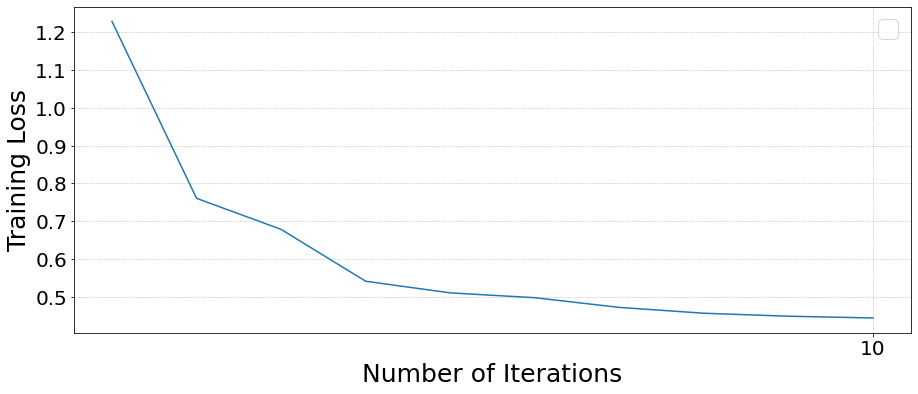

No handles with labels found to put in legend.


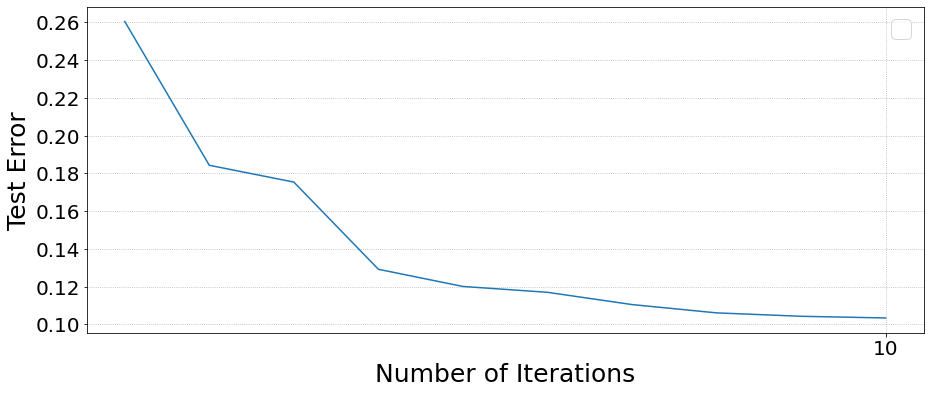

In [15]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history)
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), snvrg_test_err)
plt.show()


No handles with labels found to put in legend.


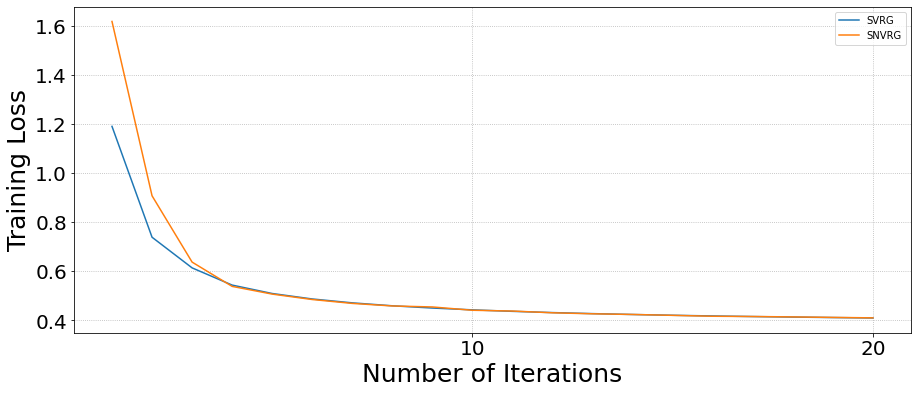

No handles with labels found to put in legend.


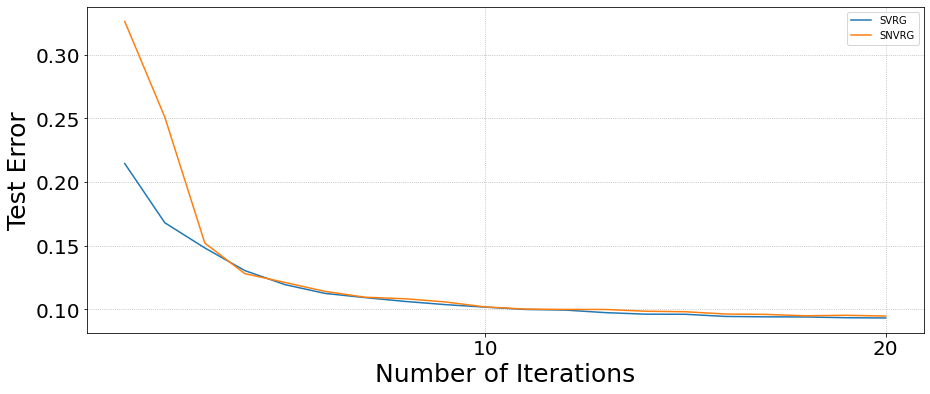

In [17]:
import random
def pack_batch(features, targets, dataset_size, batch_size):
    x_batch = []
    y_batch = []
    for i in range(batch_size):
        index = random.randint(0, dataset_size-1)
        x_batch.append(features[index])
        y_batch.append(targets[index])
    return np.array(x_batch), np.array(y_batch)

def SGD_mini(X,y, X_test, y_test, epochs, batch_size, theta, step_size, lamda):
    loss_history=[]
    test_err=[]
    for i in range(epochs):
        nBatches= int(X.shape[0]/batch_size)
        for j in range(nBatches):
            x_batch,y_batch = pack_batch(X,y,X.shape[0], batch_size)
            theta = theta- step_size*full_grad_loss(x_batch,y_batch,theta, lamda)
            
        test_err.append(1-predict(X_test,y_test,theta))
        loss_history.append(LASSO_loss(X, y, theta, lamda))
        print(i, loss_history[i])
    return loss_history, test_err

        
# def SGD(X,y,epochs, theta, step_size, X_test, y_test):
#     for i in range(epochs):
#         for j in range(X.shape[0]):
#             n = random.randint(0,X.shape[0]-1)
#             theta = theta- step_size*grad(X,y,theta, 0.01, n)
        
#         predict(X_test,y_test,theta)
        
    

In [46]:
theta = np.zeros((784,10))
# theta = np.random.rand(784,10)
epochs=100
SGD_loss_history, SGD_test_err = SGD_mini(x_train, y_train,x_test, y_test, epochs, 1 ,theta, 0.0025,  0.0001)


<ipython-input-6-a338dbd9042e>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0 0.345217580411885
1 0.32238151656771474
2 0.3140283445559273
3 0.3084075464535306
4 0.30323486793143817
5 0.3004661353563784
6 0.29825614992127303
7 0.29634274556240947
8 0.29686937243877654
9 0.2997248111833883
10 0.29491306194876393
11 0.2932054359275277
12 0.2910466160436911
13 0.2906864913468375
14 0.294842844067971
15 0.2911150328831914
16 0.29017502395313605
17 0.29523546168921316
18 0.289912106243315
19 0.2901912524779456
20 0.2900885252391896
21 0.29200903759869423
22 0.2903790797543947
23 0.2919940252245571
24 0.28928233482373944
25 0.29191389079265617
26 0.29002178727811545
27 0.2910186808933877
28 0.292374688157295
29 0.2895512122762055
30 0.2894806998021907
31 0.2890529023571931
32 0.2907422932262059
33 0.29241490726320074
34 0.2923614941954186
35 0.2907699731277738
36 0.2894665433600413
37 0.29591004073952476
38 0.289933570100088
39 0.2889827510221269
40 0.2906185129512117
41 0.2882025401471754
42 0.2908180451336429
43 0.28858966401442626
44 0.2917414453146677
45 0.28948

No handles with labels found to put in legend.


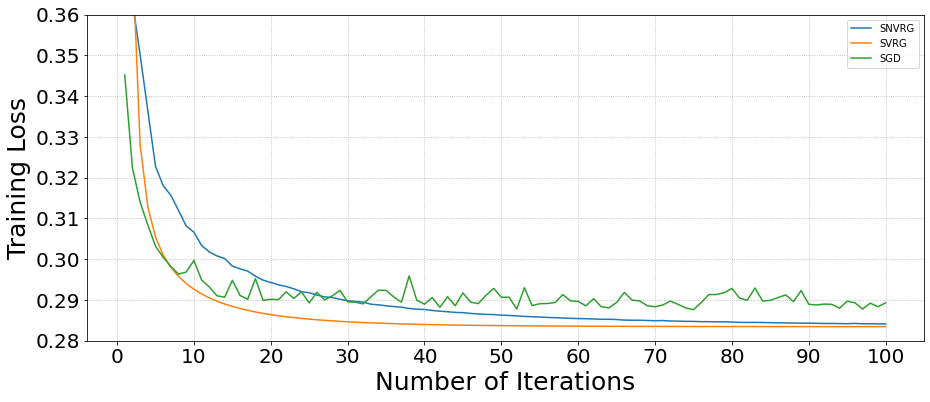

No handles with labels found to put in legend.


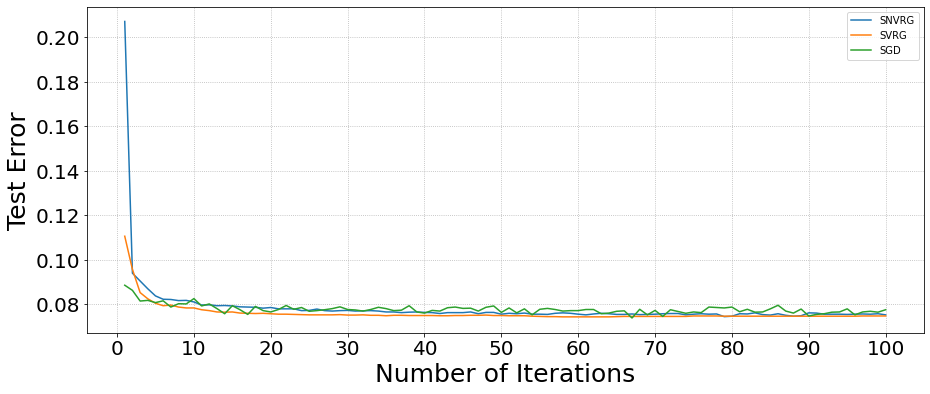

In [47]:
import matplotlib
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), SGD_loss_history,  label ="SGD")
axes = plt.gca()
axes.set_ylim([0.28, 0.36])
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), snvrg_test_err, label="SNVRG")
plt.plot(np.arange(1,epochs+1,1), svrg_test_err, label = "SVRG")
plt.plot(np.arange(1,epochs+1,1), SGD_test_err, label = "SGD")
plt.legend()
plt.show()


In [130]:
def subset_idx(data, classes):
    idx=[]
    for i in range(data.shape[0]):
        if data[i] in classes:
            idx.append(i)
    return idx

def subset_classes_data(x_train, y_train, x_test, y_test, classes):
    # Subset 'plane' and 'car' classes to perform logistic regression

    idx_train = subset_idx(y_train, classes)
    idx_test = subset_idx(y_test, classes)
    
    x_train = x_train[idx_train, :]
    y_train = y_train[idx_train]

    x_test = x_test[idx_test, :]
    y_test = y_test[idx_test]
    
    return x_train, y_train, x_test, y_test

from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)
x_train = np.reshape(x_train, (x_train.shape[0], 32*32*3))
x_test = np.reshape(x_test, (x_test.shape[0], 32*32*3))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Xm=np.mean(x_train, axis=0)
# Xd =np.std(x_train, axis=0)
# Xm = np.tile(Xm, (x_train.shape[0],1))
# x_train = x_train - Xm
# x_train = x_train/Xd

# Xm=np.mean(x_test, axis=0)
# Xd =np.std(x_test, axis=0)
# Xm = np.tile(Xm, (x_test.shape[0],1))
# x_test = x_test - Xm
# x_test = x_test/Xd

x_train /= 255
x_test /= 255


classes=[0,1,2]
x_train, y_train,x_test, y_test= subset_classes_data(x_train, y_train, x_test, y_test, classes)

y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


x_train shape: (15000, 3072)
15000 train samples
3000 test samples


In [48]:
# import numpy
# np.savetxt("svrg_loss.csv", svrg_loss_history, delimiter=",")
# np.savetxt("svrg_err.csv", svrg_test_err, delimiter=",")

# np.savetxt("SGD_005_loss.csv", SGD_loss_history, delimiter=",")
# np.savetxt("SGD_005_err.csv", SGD_test_err, delimiter=",")

# np.savetxt("SGD_005_loss.csv", SGD_loss_history, delimiter=",")
# np.savetxt("SGD_005_err.csv", SGD_test_err, delimiter=",")

# np.savetxt("SGD_0025_loss.csv", SGD_loss_history, delimiter=",")
# np.savetxt("SGD_0025_err.csv", SGD_test_err, delimiter=",")


# np.savetxt("snvrg_loss_mnist.csv", snvrg_loss_history, delimiter=",")
# np.savetxt("snvrg_err_mnist.csv", snvrg_test_err, delimiter=",")


In [157]:
theta = np.zeros((3072,3))
SGD_mini(x_train, y_train,100, 1000,theta, 0.005,  x_train, y_train)

<ipython-input-4-472b789fbdb7>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(sum((pred==corr).astype(np.int))/y_test.shape[0])


0.5670048269655568
0.5686819929640841
0.5814857236357687
0.5681502086230876
0.6099566391229649
0.6059887098093758
0.582099320952303
0.5790722408574
0.5751452180315798
0.6119610570236439
0.5864354086558128
0.595393929477215
0.6240284709154872
0.6279145872535384
0.6041888243475415
0.6024707518612452
0.617074367994764
0.5714227276446044
0.5909760287981674
0.6224331178924978
0.6155608279473125
0.6103247975128856
0.6135564100466334
0.5695001227194633
0.6064795876626032
0.6126155608279473
0.6153153890206987
0.6372003599770923
0.6395729362676921
0.6392456843655404
0.63965474924323
0.6299190051542175
0.6238648449644113
0.6369140145627097
0.6401047206086885
0.6364640431972511
0.5989527939131146
0.6107338623905751
0.6294690337887588
0.6389184324633886
0.6040661048842346
0.5871308189478851
0.6419046060705228
0.5973165344023562
0.6158471733616951
0.601611715618097
0.6391638713900024
0.6147017917041643
0.638591180561237
0.6086476315143582
0.6185470015544465
0.637527611879244
0.6462816002618015
0.63

In [152]:
from scipy.io import loadmat
from sklearn.preprocessing import LabelBinarizer

train_raw = loadmat('svhn_data/train_32x32')
test_raw = loadmat('svhn_data/test_32x32')

x_train = np.array(train_raw['X'])
x_test = np.array(test_raw['X'])

y_train = train_raw['y']
y_test = test_raw['y']


x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1, 0)

x_train = np.reshape(x_train, (x_train.shape[0], 32*32*3))
x_test = np.reshape(x_test, (x_test.shape[0], 32*32*3))

x_train = x_train.astype('float64')
x_test = x_test.astype('float64')
# Convert train and test labels into 'int64' type

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

x_train /= 255.0
x_test /= 255.0

y_train = y_train[:,0]
y_test = y_test[:,0]

classes=[0,1,2]
x_train, y_train,x_test, y_test= subset_classes_data(x_train, y_train, x_test, y_test, classes)

y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))

# lb = LabelBinarizer()
# y_train = lb.fit_transform(y_train)
# y_test = lb.fit_transform(y_test)

In [43]:
snvrg_loss_history

[1.2208560105449666,
 0.3633115722803657,
 0.3501492432564448,
 0.33646299788463196,
 0.3228182342062415,
 0.31803729444545686,
 0.31569168935697706,
 0.3119410618910537,
 0.30814708307150523,
 0.30664013693818304,
 0.30337719145646025,
 0.301785147516993,
 0.3008211442906492,
 0.30018017678192593,
 0.2983092925434492,
 0.2976473013319749,
 0.29709469067201344,
 0.2958330433385344,
 0.2948787581443111,
 0.294301234373271,
 0.2937193992735556,
 0.2933265157672904,
 0.2927508439522505,
 0.292030021725773,
 0.29179764242240225,
 0.29122882770922764,
 0.29076996713386516,
 0.2905964573133735,
 0.29019723997241104,
 0.2898336166102767,
 0.28965575486514744,
 0.28949038404747784,
 0.28898257370883496,
 0.288822468248346,
 0.2885894234937905,
 0.2883932789276683,
 0.28824825337493326,
 0.2879411079485052,
 0.28775029456888235,
 0.2876853508660018,
 0.28744165421751877,
 0.28726909343172297,
 0.2871351315820663,
 0.2869598850823092,
 0.2869054837153009,
 0.28671109159983044,
 0.286585149211610

In [ ]:
0 1.2974267549568215
1 0.737577578361009
2 0.5911393274995395
3 0.4114433399341639
4 0.37519321433315916
5 0.3461043918234689
6 0.32312593938673667
7 0.3531513737923464
8 0.5644702367411936
9 0.35571094944282394
10 0.33438475290017217
11 0.33863998331008466
12 0.30898728305236034
13 0.32607914827107454
14 0.31159486476603304
15 0.3184823795433633
16 0.32179489560871766
17 0.30094381399684134
18 0.3152169653077195
19 0.29303427233807244
20 0.29415479843611475
21 0.28804806628691926
22 0.29003723758879085
23 0.28927910922975963
24 0.29076216881425865
25 0.2878164936114675
26 0.28629474533709465
27 0.28708379246803933
28 0.2862924007639312
29 0.28540230767862224
30 0.28805676038008554
31 0.28979079813722525
32 0.28856606380899646
33 0.2885546391006481
34 0.2867290257918486
35 0.28717343639676673
36 0.2857383432639139
37 0.28520492296287014
38 0.2858066674522002
39 0.2846830376788169
40 0.2851125296569227
41 0.2872601937742773
42 0.28734883661234917
43 0.2857667164501603
44 0.2861888518672362
45 0.28768234096153034
46 0.28605527904524175
47 0.28606125563457147
48 0.2865799655373089
49 0.2855581321657627
50 0.2947805914869893
51 0.2856421700693799
52 0.28561812254828817
53 0.28581684473837377
54 0.2878056290292795
55 0.2859527266350078
56 0.28558701649416984
57 0.2853399368806619
58 0.2859984291663949
59 0.28602524596017986
60 0.2867327296830305
61 0.2909152037819462
62 0.2887344935999494
63 0.30620280902894015
64 0.3134380249590759
65 0.3148388957736144
66 0.30547020746053705
67 0.2924211248193541
68 0.29294721707290805
69 0.2948070827072584
70 0.293752501008083
71 0.2900991604849634
72 0.288666469478419
73 0.2907505860860008
74 0.2906466118796656
75 0.29610276584616985
76 0.292086197941861
77 0.29289873125729765
78 0.2892121699421559
79 0.29642624965095726
80 0.2953128433154732
81 0.29218039954427677
82 0.29061555754259566
83 0.2954779466278614
84 0.2918931288070698
85 0.3003948988369761
86 0.30319299970464597
87 0.29579086967705964
88 0.2954839298149088
89 0.29282283848448765
90 0.3094879326462206
91 0.30128365192702145
92 0.29461682372832476
93 0.29354476532574136
94 0.28953790138853996
95 0.294081766940301
96 0.2908250470005427
97 0.2898335751265196
98 0.2870009789761279
99 0.28696006265405904